In [1]:
# Load Library
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import sklearn
import libsvm
from libsvm.svmutil import *
import pandas as pd
import seaborn as sns

%matplotlib inline
set.seed(42)

In [2]:
# Load Train Data
Data = pd.read_csv("Train.csv")
Data['Neighbourhood'] = Data['Neighbourhood'].astype(str)
Y = Data['Decision']
X = Data.drop(['Decision'], axis=1)

In [3]:
# Load Test Data
Test = pd.read_csv("Test.csv")
Test['Neighbourhood'] = Test['Neighbourhood'].astype(str)
Test.head()

,Host_is_superhost,Host_identity_verified,Neighbourhood,Room_type,Accommodates,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,28806,Private room,1,4,3,1,1,58.0,137,4.85,0,September
1,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,573,4.93,1,June
2,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,590,4.93,1,August
3,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,600,4.93,1,September
4,1,1,28805,Entire home/apt,2,5,5,1,1,76.0,581,4.93,1,July


# Regression Analysis
## Data Processing 

In [4]:
def Encode(airbnb):
    for column in airbnb.columns[airbnb.columns.isin(['Room_type', 'Month','Neighbourhood'])]:
        airbnb[column] = airbnb[column].factorize()[0]
    return airbnb

X_data = Encode(X.copy())
Test_data = Encode(Test.copy())

In [5]:
Test_data.head()

,Host_is_superhost,Host_identity_verified,Neighbourhood,Room_type,Accommodates,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,0,0,1,4,3,1,1,58.0,137,4.85,0,0
1,1,1,1,1,2,5,5,1,1,76.0,573,4.93,1,1
2,1,1,1,1,2,5,5,1,1,76.0,590,4.93,1,2
3,1,1,1,1,2,5,5,1,1,76.0,600,4.93,1,0
4,1,1,1,1,2,5,5,1,1,76.0,581,4.93,1,3


## Base Model

In [6]:
# Split Data: 20% Test, 80% Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,Y, test_size=0.2, random_state=1)

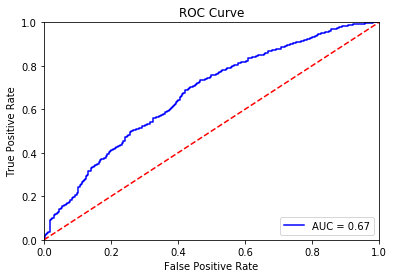

the accuracy score is 0.6682274247491639


In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from scipy.stats import sem
from numpy import mean
from numpy import std
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# define model
model = LogisticRegression(solver='liblinear',max_iter=1000)
# fit a model
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test,lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prediction = model.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

## Optimization Using GridSearchCV

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# K fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    model = LogisticRegression(max_iter=1000)
    

    print(np.unique(y_test, return_counts=True))

    model.fit(X_train, y_train)
    report = classification_report(y_test, model.predict(X_test))
    print(report)

# Hyperparameter Space
## solver space 
solver = ['liblinear']
## Penalty space
penalty = ['l1', 'l2']
## Regularization hyperparameter space
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty,solver = solver)

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

grid_search.fit(X_data, Y)
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_data, Y)
print('Tuned scores:', cv_scores)
print('Best parameters:', grid_search.best_params_)

(array([0, 1]), array([548, 947]))
              precision    recall  f1-score   support

           0       0.58      0.34      0.43       548
           1       0.69      0.86      0.77       947

    accuracy                           0.67      1495
   macro avg       0.64      0.60      0.60      1495
weighted avg       0.65      0.67      0.64      1495

(array([0, 1]), array([548, 947]))
              precision    recall  f1-score   support

           0       0.58      0.34      0.43       548
           1       0.69      0.86      0.77       947

    accuracy                           0.67      1495
   macro avg       0.64      0.60      0.60      1495
weighted avg       0.65      0.67      0.64      1495

(array([0, 1]), array([548, 947]))
              precision    recall  f1-score   support

           0       0.58      0.34      0.43       548
           1       0.69      0.86      0.77       947

    accuracy                           0.67      1495
   macro avg       0.64

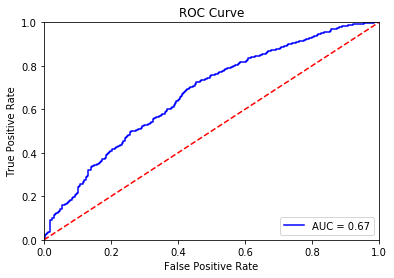

the accuracy score is 0.6662207357859532


In [10]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# define model
model = LogisticRegression(penalty='l2',solver='liblinear', C = 742636826811269, max_iter=1000)
# fit a model
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test,lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prediction = model.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

# Decision Tree
## Base Model 

In [12]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

cart_tree = tree.DecisionTreeClassifier(criterion='gini', random_state=42)
cart_tree.fit(X_train,y_train)
prediction = cart_tree.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

the accuracy score is 0.7491638795986622


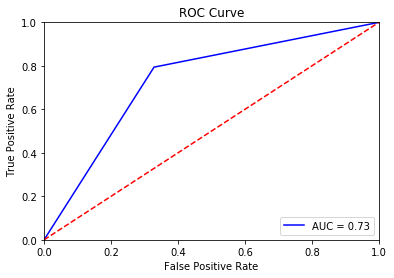

the accuracy score is 0.7491638795986622


In [13]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# define model
model = tree.DecisionTreeClassifier(criterion='gini', random_state=42)
# fit a model
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test,lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prediction = model.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

In [14]:
submission = pd.read_csv("sample_submission.csv")
submission['Decision'] = cart_tree.predict(Test_data)
pd.DataFrame(submission).to_csv("prediction_Decision_Tree.csv",index=False)

## Improve Model Using GridSearchCV

In [15]:
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# K fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):

    cart_tree = tree.DecisionTreeClassifier(max_depth = 3, criterion='gini', random_state=42)

    print(np.unique(y_test, return_counts=True))

    cart_tree.fit(X_train, y_train)
    report = classification_report(y_test, cart_tree.predict(X_test))
    print(report)

# parameter tuning with gridsearchCV

parameter_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'max_features': [1, 2, 3, 4]
}

cart_tree = tree.DecisionTreeClassifier(criterion='gini', random_state=42)
grid_search = GridSearchCV(cart_tree, param_grid=parameter_grid, cv=kf, refit=True)

grid_search.fit(X_data, Y)
best_tree = grid_search.best_estimator_
cv_scores = cross_val_score(best_tree, X_data, Y)
print('Tuned scores:', cv_scores)
print('Best parameters:', grid_search.best_params_)

(array([0, 1]), array([548, 947]))
              precision    recall  f1-score   support

           0       0.61      0.31      0.41       548
           1       0.69      0.88      0.78       947

    accuracy                           0.67      1495
   macro avg       0.65      0.60      0.59      1495
weighted avg       0.66      0.67      0.64      1495

(array([0, 1]), array([548, 947]))
              precision    recall  f1-score   support

           0       0.61      0.31      0.41       548
           1       0.69      0.88      0.78       947

    accuracy                           0.67      1495
   macro avg       0.65      0.60      0.59      1495
weighted avg       0.66      0.67      0.64      1495

(array([0, 1]), array([548, 947]))
              precision    recall  f1-score   support

           0       0.61      0.31      0.41       548
           1       0.69      0.88      0.78       947

    accuracy                           0.67      1495
   macro avg       0.65

In [16]:
# Best parameters: {'max_depth': 5, 'max_features': 4}
cart_tree = tree.DecisionTreeClassifier(criterion='gini', random_state=42, max_depth = 5, max_features = 4)
cart_tree.fit(X_train,y_train)
prediction = cart_tree.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

the accuracy score is 0.6729096989966555


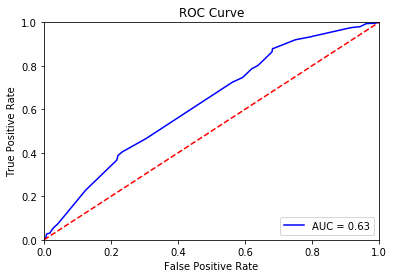

the accuracy score is 0.6729096989966555


In [17]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# define model
model = tree.DecisionTreeClassifier(criterion='gini', random_state=42, max_depth = 5, max_features = 4)
# fit a model
model.fit(X_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test,lr_probs)
roc_auc = metrics.auc(fpr, tpr)

# plot
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
prediction = model.predict(X_test)
print('the accuracy score is',accuracy_score(y_test, prediction))

In [18]:
submission = pd.read_csv("sample_submission.csv")
submission['Decision'] = cart_tree.predict(Test_data)
pd.DataFrame(submission).to_csv("improved_prediction_Decision_Tree.csv",index=False)

# KNN
## Base Model

In [19]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

KNeighborsClassifier()

In [37]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('the accuracy score is',accuracy_score(y_test, y_pred))

[[192 356]
 [152 795]]
              precision    recall  f1-score   support

           0       0.56      0.35      0.43       548
           1       0.69      0.84      0.76       947

    accuracy                           0.66      1495
   macro avg       0.62      0.59      0.59      1495
weighted avg       0.64      0.66      0.64      1495

the accuracy score is 0.6602006688963211


## Optimize and tune value of K

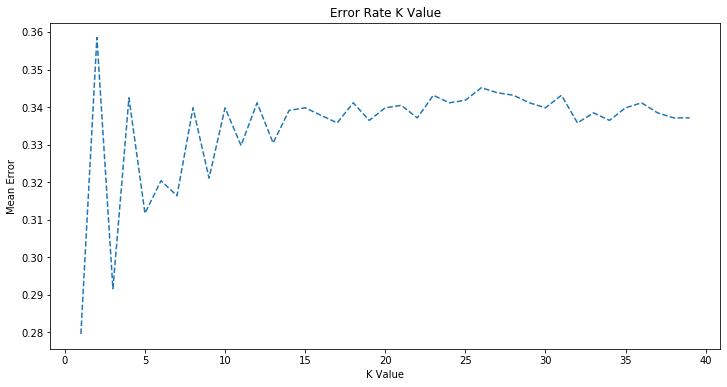

In [33]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.plot(range(1, 40), error,linestyle='dashed')

In [34]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=20)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [36]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('the accuracy score is',accuracy_score(y_test, y_pred))

[[192 356]
 [152 795]]
              precision    recall  f1-score   support

           0       0.56      0.35      0.43       548
           1       0.69      0.84      0.76       947

    accuracy                           0.66      1495
   macro avg       0.62      0.59      0.59      1495
weighted avg       0.64      0.66      0.64      1495

the accuracy score is 0.6602006688963211


In [38]:
submission = pd.read_csv("sample_submission.csv")
submission['Decision'] = classifier.predict(Test_data) 
pd.DataFrame(submission).to_csv("KNN_Submission.csv",index=False)

# Adaboost
## Base Model: Decision Tree Classifier

In [147]:
# AdaBoost uses Decision Tree Classifier as default Classifier.
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [148]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('the accuracy score is',accuracy_score(y_test, y_pred))

[[216 332]
 [135 812]]
              precision    recall  f1-score   support

           0       0.62      0.39      0.48       548
           1       0.71      0.86      0.78       947

    accuracy                           0.69      1495
   macro avg       0.66      0.63      0.63      1495
weighted avg       0.68      0.69      0.67      1495

the accuracy score is 0.6876254180602007


## SVC
### Sigmoid Kernel

In [152]:
from sklearn.svm import SVC
svc=SVC(probability=True, kernel='sigmoid')
# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=5, base_estimator=svc,learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = model.predict(X_test)

In [164]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print('the accuracy score is',accuracy_score(y_test, y_pred))

[[  0 548]
 [  0 947]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       548
           1       0.63      1.00      0.78       947

    accuracy                           0.63      1495
   macro avg       0.32      0.50      0.39      1495
weighted avg       0.40      0.63      0.49      1495

the accuracy score is 0.6334448160535117


### RBF Kernel: Base Case

In [165]:
from sklearn.svm import SVC
svc=SVC(probability=True, kernel='rbf')
# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=5, base_estimator=svc,learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = model.predict(X_test)

In [167]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print('the accuracy score is',accuracy_score(y_test, y_pred))

[[  0 548]
 [  0 947]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       548
           1       0.63      1.00      0.78       947

    accuracy                           0.63      1495
   macro avg       0.32      0.50      0.39      1495
weighted avg       0.40      0.63      0.49      1495

the accuracy score is 0.6334448160535117


### Optimization Using GridSearchCV

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

model = SVC()
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

# XGBoost

In [137]:
import xgboost as xgb

In [138]:
dtrain = xgb.DMatrix(X_train, label=y_train.values)
dtest = xgb.DMatrix(X_test, label=y_test.values)

In [139]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [140]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.644975	train-auc:0.642677
[1]	eval-auc:0.646843	train-auc:0.663158
[2]	eval-auc:0.669924	train-auc:0.691616
[3]	eval-auc:0.671116	train-auc:0.709424
[4]	eval-auc:0.676613	train-auc:0.720041
[5]	eval-auc:0.682276	train-auc:0.725852
[6]	eval-auc:0.691853	train-auc:0.731057
[7]	eval-auc:0.696434	train-auc:0.735991
[8]	eval-auc:0.696751	train-auc:0.738127
[9]	eval-auc:0.704792	train-auc:0.74208


In [141]:
ypred = np.array(bst.predict(xgb.DMatrix(X_test)))
ypred_bst  = ypred > 0.5  
ypred_bst = ypred_bst.astype(int)  
print(confusion_matrix(y_test, ypred_bst))
print(classification_report(y_test, ypred_bst))
print('the accuracy score is',accuracy_score(y_test, ypred_bst))

[[178 370]
 [103 844]]
              precision    recall  f1-score   support

           0       0.63      0.32      0.43       548
           1       0.70      0.89      0.78       947

    accuracy                           0.68      1495
   macro avg       0.66      0.61      0.61      1495
weighted avg       0.67      0.68      0.65      1495

the accuracy score is 0.6836120401337793


In [142]:
len(ypred_bst)

1495

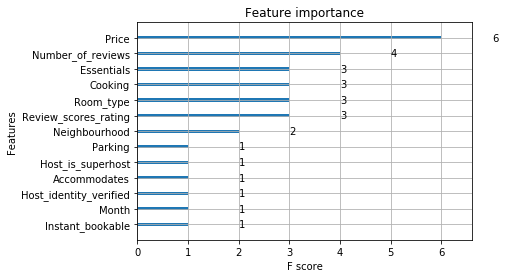

In [143]:
xgb.plot_importance(bst)

In [144]:
ypred = np.array(bst.predict(xgb.DMatrix(Test_data)))
ypred_bst  = ypred > 0.5  
ypred_bst = ypred_bst.astype(int)  

In [145]:
submission = pd.read_csv("sample_submission.csv")
submission['Decision'] = ypred_bst
pd.DataFrame(submission).to_csv("XGBoost_Submission.csv",index=False)